In [1]:
import fastai
from fastai import *          # Quick access to most common functionality
from fastai.vision import *   # Quick access to computer vision functionality

In [2]:
PATH = Path('/DATA/kaggle/imgnetloc/ILSVRC/Data/CLS-LOC/')
PATH_TRN = PATH/'train'

sz_lr=128
scale,bs = 4,64
sz_hr = sz_lr*scale

In [3]:
class ImageToImageDataset(ImageDatasetBase):
    "A dataset for segmentation task."
    def __init__(self, x:FilePathList, y:FilePathList, **kwargs):
        assert len(x)==len(y)
        super().__init__(x=x, y=y, **kwargs)
        self.loss_func = F.mse_loss

    def _get_y(self,i,x):  return self.image_opener(self.y[i])

    def reconstruct_output(self, out, x): 
        return Image(out)

In [4]:
classes = list(PATH_TRN.iterdir())
fnames_full = []
for class_folder in progress_bar(classes):
    for fname in class_folder.iterdir():
        fnames_full.append(fname)

np.random.seed(42)
keep_pct = 0.05
keeps = np.random.rand(len(fnames_full)) < keep_pct
image_fns = np.array(fnames_full, copy=False)[keeps]
len(image_fns)

63537

In [5]:
valid_pct = 0.2
src = (ImageFileList
      .from_df(pd.DataFrame(image_fns), 0)
      .label_from_func(lambda x: x)
      .random_split_by_pct(valid_pct))

In [6]:
def get_sr_transforms():
    res = []
    res.append(dihedral_affine(p=0.5))
    return (res, [])

data = (src.datasets(ImageToImageDataset)
        .transform(get_transforms(), y_kwargs={'size': sz_hr}, size=sz_lr, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats, tfm_y=True))

In [7]:
x,y = next(iter(data.valid_dl))
x.shape, y.shape

(torch.Size([96, 3, 128, 128]), torch.Size([96, 3, 512, 512]))

In [8]:
x,y = next(iter(data.valid_dl))
x.shape, y.shape

(torch.Size([96, 3, 128, 128]), torch.Size([96, 3, 512, 512]))

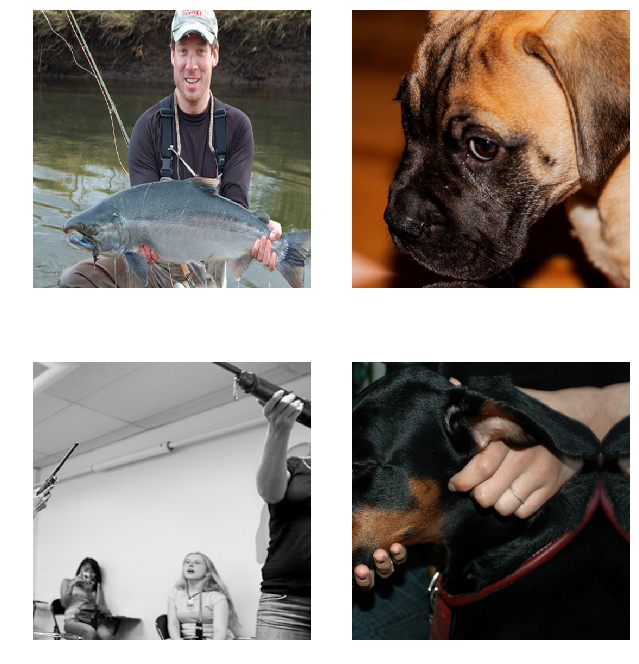

In [9]:
data.show_batch(2)

In [10]:
def conv(ni, nf, kernel_size=3, actn=True):
    layers = [nn.Conv2d(ni, nf, kernel_size, padding=kernel_size//2)]
    if actn: layers.append(nn.ReLU(True))
    return nn.Sequential(*layers)

In [11]:
class ResSequential(nn.Module):
    def __init__(self, layers, res_scale=1.0):
        super().__init__()
        self.res_scale = res_scale
        self.m = nn.Sequential(*layers)

    def forward(self, x):
        x = x + self.m(x) * self.res_scale
        return x

In [12]:
def res_block(nf):
    return ResSequential(
        [conv(nf, nf), conv(nf, nf, actn=False)],
        0.1)

In [13]:
def upsample(ni, nf, scale):
    layers = []
    for i in range(int(math.log(scale,2))):
        layers += [conv(ni, nf*4), nn.PixelShuffle(2)]
    return nn.Sequential(*layers)

In [14]:
class SrResnet(nn.Module):
    def __init__(self, nf, scale):
        super().__init__()
        features = [conv(3, 64)]
        for i in range(8): features.append(res_block(64))
        features += [conv(64,64), upsample(64, 64, scale),
                     nn.BatchNorm2d(64),
                     conv(64, 3, actn=False)]
        self.features = nn.Sequential(*features)
        
    def forward(self, x): return self.features(x)

In [15]:
model = SrResnet(64, scale)
model = nn.DataParallel(model).cuda()

In [16]:
learn = ImageLearner(data, model, loss_func=F.mse_loss)

In [17]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


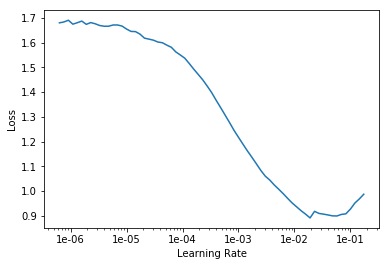

In [18]:
learn.recorder.plot()

In [19]:
lr = 1e-3

In [20]:
learn.fit_one_cycle(100, lr)

epoch,train_loss,valid_loss
1,0.114694,0.081932
2,0.107616,0.075846
3,0.111638,0.078980
4,0.105800,0.074728
5,0.106506,0.073445
6,0.104084,0.074006
7,0.106901,0.072596
8,0.106365,0.073568


KeyboardInterrupt: 

In [21]:
learn.save('enhance')

In [22]:
learn = learn.load('enhance')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


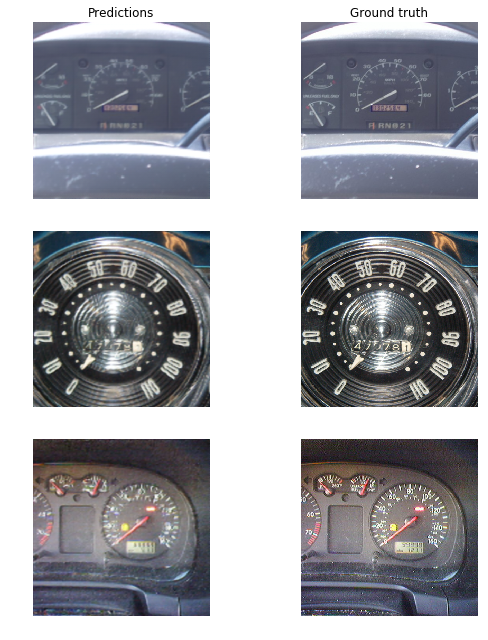

In [23]:
learn.show_results()

In [ ]:
learn.fit_one_cycle(50, lr/10)